In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random

##### Load the dataset, the dataset originated from MNIST has been curated. The training and testing data still contain 10 digits, but the task is to classify zero from non-zero digits, so the labels are curated as either one for digit 0 or zero for other digits. In order to balance the data for training, the training data contains 2000 digit 0 images, and 2000 images for other digits. The testing images are the first 1000 images from the original evaluation set, note the code maynot work if you feed it with images from other datasets

In [2]:
# load the dataset and normalize
data_file = open('zero_nonzero.pkl', 'rb')
train_data, train_labels, test_data, test_labels = pickle.load(data_file, encoding='latin1')
data_file.close()

# normalize the data, note that the testing data has to be manipulated in the same way as the training data
train_data = (train_data - np.mean(train_data)) / np.std(train_data)
test_data = (test_data - np.mean(train_data)) / np.std(train_data)

# some dummy manipulation for later use
train_data = np.reshape(train_data, [-1, 28, 28])
test_data = np.reshape(test_data, [-1, 28, 28])
train_labels = train_labels.astype(np.float32)
test_labels = test_labels.astype(np.float32)

#### Let's take a look at the training and testing data and labels, and an example image

In [3]:
print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(4000, 28, 28)
(4000, 1)
(1000, 28, 28)
(1000, 1)


label:  [0.]


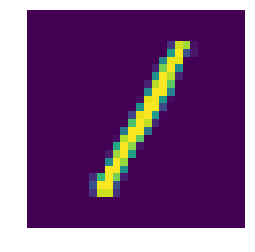

label:  [1.]


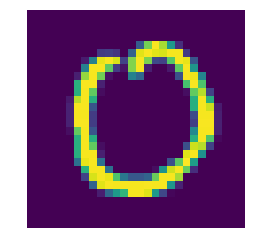

In [4]:
# Visualize the image, note that label for digit 0 is one, and zero for other digits
plt.figure(1)
img = test_data[0, :, :].reshape(28, 28)
print('label: ', test_labels[0, :])
plt.imshow(img)
plt.axis('off')
plt.show()

plt.figure(2)
img = test_data[6, :, :].reshape(28, 28)
print('label: ', test_labels[6, :])
plt.imshow(img)
plt.axis('off')
plt.show()

#### Let's define some hyperparameters for the CNN, and some statistics variables to track the loss and accuracy

In [5]:
hm_train, dim1, dim2 = train_data.shape
hm_test = len(test_labels)
hm_classes = 2
batch_size = 2
max_epoch = 1
eval_interval = 50
learning_rate = 0.001

test_acc = np.zeros((0, 1))
train_acc = np.zeros((0, 1))
loss = np.zeros((0, 1))

#### Core functions for the forward propagation

In [6]:
# Initialize the weights, typically, the weights should be some small random numbers, but since this is a simple demo
# we can initialize them in the following way
def init_weight(shape):
    w = np.ones(shape) / 100
    #w = np.abs(np.random.randn(shape[0], shape[1])) / 100
    return w


def init_bias(shape):
    b = np.ones(shape) * 0.001
    return b


# Sigmoid function and its gradient
def sigmoid_act(x):
    return 1 / (1 + np.exp(-x))
    
    
def sigmoid_grad(x):
    return sigmoid_act(x) * (1 - sigmoid_act(x))


# Relu activation function and its gradient
def Relu_act(x):
    return (x > 0) * x


def Relu_grad(x):
    return (x > 0) * 1.0

In [7]:
# Convolve the image with a given filter
def conv2d_np(images, filt2d):
    hm_im, d1, d2 = images.shape
    
    # default stride 1 and square filter with size 5, in our particular example
    stride = 1
    filter_size = 5
    conv_im = np.zeros([hm_im, int((d1-filter_size)/stride + 1), int((d2-filter_size)/stride + 1)])
    
    # convolve with the input images
    for im in np.arange(int(hm_im)):
        for i in np.arange(int((d1-filter_size+1)/stride)):
            for j in np.arange(int((d2-filter_size+1)/stride)):
                # convolution is done by the element-wise multiplication between the filter and the reception area
                # the result is the sum of this matrix
                recep_area = images[im, i:i+filter_size, j:j+filter_size]
                conv_im[im, i, j] = np.sum(recep_area * filt2d)
                
    return conv_im

In [8]:
# Different pooling scenarios, both are commonly used
def avg_pool3(images):
    hm_im, d1, d2 = images.shape
    # by default, the stride is 3, and the kernel is 3 x 3 in our example
    stride = 3
    kernel_size = 3
    pooled_im = np.zeros([hm_im, int((d1-kernel_size)/stride + 1), int((d2-kernel_size)/stride + 1)])
    for im in np.arange(int(hm_im)):
        for i in np.arange(int((d1-kernel_size)/stride + 1)):
            for j in np.arange(int((d2-kernel_size)/stride + 1)):
                # average the values in the reception area and preduce one output
                recep_area = images[im, i * stride:i * stride + kernel_size, j * stride:j * stride + kernel_size]
                pooled_im[im, i, j] = np.mean(recep_area)
                
    return pooled_im

def max_pool3(images):
    hm_im, d1, d2 = images.shape
    # by default, the stride is 3, and the kernel is 3 x 3 in our example
    stride = 3
    kernel_size = 3
    pooled_im = np.zeros([hm_im, int((d1-kernel_size)/stride + 1), int((d2-kernel_size)/stride + 1)])
    ind_set = np.zeros([hm_im, 64, 2])
    
    for im in np.arange(int(hm_im)):
        counter = 0
        for i in np.arange(int((d1-kernel_size)/stride + 1)):
            for j in np.arange(int((d2-kernel_size)/stride + 1)):
                recep_area = images[im, i * stride:i * stride + kernel_size, j * stride:j * stride + kernel_size]
                
                # keep track of the indices for the fired value in each reception area, 
                # we will use this index in later phase when we compute the gradients
                ind = np.unravel_index(np.argmax(recep_area, axis=None), recep_area.shape)
                pooled_im[im, i, j] = recep_area[ind]
                ind_set[im, counter, :] = ind
                counter += 1
                
    return pooled_im, ind_set.astype(np.int32)

In [9]:
# compute the prediction accuracy
def compute_accuracy(data, labels, W, ind_set, pool='AVERAGE'):
    h_conv1 = Relu_act(conv2d_np(data, W['w']) + W['b'])
    if pool == 'AVERAGE':
        h_pool1 = avg_pool3(h_conv1)
    else:
        h_pool1, _ = max_pool3(h_conv1)

    fc = h_pool1.reshape(-1, 64)
    y_out = np.dot(fc, W['w_fc']) + W['b_fc']
    
    # if the value is greater than zero, we label it as one
    pred_labels = ((y_out > 0) * 1.0).reshape(len(labels), 1)
    
    return np.mean(np.equal(pred_labels, labels) * 1.0)

In [10]:
# sigmoid cross entropy loss function
def compute_ce_sigmoid_loss(y_out, y):
    # note that the y_out is the unfired value, namely, the value before the sigmoid function,
    # this implementation will avoid underflow, since the log is involved
    return np.sum(y_out - y_out * y + np.log(1 + np.exp(-y_out)))

In [11]:
# compute the gradients!
# This is the key for training a CNN, but it is pretty straightforward
# Let's break it down piece by piece
def compute_gradients(W, x, h_conv1, fc, y, y_hat, ind_set, pool='AVERAGE'):
    # initialize the gradients to return
    Grad_W = {'w': np.zeros([5, 5]), 'b': np.zeros([24, 24]), \
        'w_fc': np.zeros([64, 1]), 'b_fc': np.zeros([1, 1])}
    
    # Delta_y_hat = -y * 1 / y_hat + (1-y) * 1 / (1 - y_hat), simple
    # Dy_hat / D_w = y_hat(1 - y_hat) * h
    Grad_W['w_fc'] = np.dot(np.transpose(fc), y_hat - y)
    Grad_W['b_fc'] = np.sum(y_hat - y)
    Grad_fc = np.dot(y_hat - y, np.transpose(W['w_fc']))
    
    stride = 3
    act1 = np.zeros([24, 24])
    for im in np.arange(len(y)):
        one_im = Grad_fc[im, :]
        pool1 = one_im.reshape(8, 8)

        counter = 0
        for i in np.arange(8):
            for j in np.arange(8):
                if pool == 'AVERAGE':
                    # the gradient will be uniformly distributed back to the original reception area
                    act1[i*stride:i*stride+stride, j*stride:j*stride+stride] = \
                        np.ones([stride, stride]) * pool1[i, j] / (stride * stride)
                else:
                    temp_map = np.zeros([stride, stride])
                    temp_map[ind_set[im, counter, :]] = pool1[i, j]
                    # only the entry in the index set will take the full gradient, other entries would be zero
                    act1[i*stride:i*stride+stride, j*stride:j*stride+stride] = temp_map
                        
        # Gradient for the Relu   
        Grad_C1 = (h_conv1[im, :, :].reshape(24, 24) > 0) * act1
        
        # Gradient for the bias
        Grad_W['b'] += Grad_C1
        
        f1 = np.zeros([5, 5])
        for r in np.arange(5):
            for c in np.arange(5):
                f1[r, c] = np.sum(x[im, r:r+24, c:c+24].reshape(24, 24) * Grad_C1)
        
        # Gradient for the filter2d
        Grad_W['w'] += f1
        
    return Grad_W

In [12]:
# Define the standard stachatic gradient descent
def SGDtrain_opts(W, Grad_W, learning_rate):
    W['w'] -= learning_rate * Grad_W['w']
    W['b'] -= learning_rate * Grad_W['b']
    W['w_fc'] -= learning_rate * Grad_W['w_fc']
    W['b_fc'] -= learning_rate * Grad_W['b_fc']
    
    return W

#### Now we start to train the simple CNN, I will print the loss and accuracy every 100 iterations, after one epoch's training, the testing accuracy will hit over 98%, the CNN is indeed powerful, don't forget that we only have one filter(5*5=25 parameters), one bias(24*24=576 parameters), weights between FC layer and the output layer(64+1=65 parameters), totally 666 parameters.

In [13]:
# Initialize the weights and index_set, note that the index set size is not fixed, it depends on the batch_size
W = {'w': init_weight([5, 5]), 'b': init_bias([24, 24]), \
                'w_fc': init_weight([64, 1]), 'b_fc': init_bias([1, 1])}
ind_set = np.zeros([batch_size, 64, 2])

for epoch in np.arange(max_epoch):
        # reshuffle the data after each epoch
        re_order = np.random.permutation(hm_train)
        
        for i in np.arange(int(hm_train / batch_size)):
            batch_x = train_data[re_order[i * batch_size:(i + 1) * batch_size], :, :]
            batch_y = train_labels[re_order[i * batch_size:(i + 1) * batch_size], :]
            if epoch == 0 and i == 0:
                print(batch_x.shape, batch_y.shape)
            
            # Forward propagation
            h_conv1 = Relu_act(conv2d_np(batch_x, W['w']) + W['b'])
            #h_pool1, ind_set = avg_pool3(h_conv1)
            h_pool1, ind_set = max_pool3(h_conv1)

            # feed into the fully connected layer
            fc = h_pool1.reshape(-1, 64)
            y_out = np.dot(fc, W['w_fc']) + W['b_fc']
            y_pred = sigmoid_act(y_out)
                        
            if i % eval_interval == 0:
                ce = compute_ce_sigmoid_loss(y_out, batch_y)
                test_accuracy = compute_accuracy(test_data, test_labels, W, ind_set, 'MAX')
                #test_accuracy = compute_accuracy(test_data, test_labels, W, ind_set, 'AVERAGE')
                #train_accuracy = compute_accuracy(train_data, train_labels, W, ind_set, 'MAX')
                test_acc = np.vstack((test_acc, test_accuracy))
                #train_acc = np.vstack((train_acc, train_accuracy))
                loss = np.vstack((loss, ce))
                print('Epoch', epoch, 'iteration', i, 'train loss:', np.mean(loss), 'test_acc:', test_accuracy)
                
            
            # Backward propagation
            Grad_W = compute_gradients(W, batch_x, h_conv1, fc, batch_y, y_pred, ind_set, 'MAX')
            W = SGDtrain_opts(W, Grad_W, learning_rate)
            
            # decay the learning rate if necessary
            if i == int(hm_train / batch_size / 2):
                learning_rate *= 0.5

(2, 28, 28) (2, 1)
Epoch 0 iteration 0 train loss: 1.366501825826 test_acc: 0.096
Epoch 0 iteration 50 train loss: 1.2592087002731813 test_acc: 0.096
Epoch 0 iteration 100 train loss: 1.1592556243063454 test_acc: 0.096
Epoch 0 iteration 150 train loss: 1.068714264936131 test_acc: 0.163
Epoch 0 iteration 200 train loss: 1.0057041539727467 test_acc: 0.58
Epoch 0 iteration 250 train loss: 1.081024854408825 test_acc: 0.804
Epoch 0 iteration 300 train loss: 1.029127398064196 test_acc: 0.932
Epoch 0 iteration 350 train loss: 0.9757851209113928 test_acc: 0.876
Epoch 0 iteration 400 train loss: 0.932587821354404 test_acc: 0.926
Epoch 0 iteration 450 train loss: 0.8431732266027228 test_acc: 0.953
Epoch 0 iteration 500 train loss: 0.7868714347719752 test_acc: 0.978
Epoch 0 iteration 550 train loss: 0.7218627827940672 test_acc: 0.975
Epoch 0 iteration 600 train loss: 0.6713104574257083 test_acc: 0.913
Epoch 0 iteration 650 train loss: 0.6240010718360945 test_acc: 0.974
Epoch 0 iteration 700 train